In [1]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from functions import utils
import json
import warnings
warnings.filterwarnings("ignore")

In [2]:
from dotenv import load_dotenv
load_dotenv()
HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")
os.environ["HOPSWORKS_API_KEY"] = HOPSWORKS_API_KEY

In [3]:
CITY = "dublin"
STATION_1 = "MOUNTJOY SQUARE WEST"
STATION_2 = "HEUSTON BRIDGE (NORTH)"

STATION_1 = STATION_1.replace(" ", "_")
STATION_2 = STATION_2.replace(" ", "_")

In [4]:
project = hopsworks.login()
fs = project.get_feature_store() 
# secrets = utils.secrets_api(project.name)

"""
city_secrets = json.loads(secrets.get_secret("city_secrets").value)
CITY = city_secrets["city"]
latitude = city_secrets["latitude"]
longitude = city_secrets["longitude"]

time_secrets = json.loads(secrets.get_secret("time_secrets").value)
earliest_bike_datetime = time_secrets["earliest_bike_datetime"]
last_bike_datetime = time_secrets["last_bike_datetime"]
"""

CITY = "dublin"
# latitude =
# longitude =

earliest_bike_datetime = "2023-08-05 12:56:53 UTC"
last_bike_datetime = "2025-01-06 15:06:11 UTC"

today = datetime.now()

print(type(fs))

2025-01-07 19:19:01,820 INFO: Initializing external client
2025-01-07 19:19:01,826 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-07 19:19:03,421 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1207494
<class 'hsfs.feature_store.FeatureStore'>


## Creating the feature view

In [5]:
# Retrieve feature groups
bike_fg = fs.get_feature_group(
    name='bike_data',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather_data',
    version=1,
)

In [6]:
selected_features = bike_fg.select(["num_bikes_available", "station"]).join(weather_fg.select_all(), on=['datetime'])

# selected_features.show(1056438)
selected_features.show(10)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.79s) 


,num_bikes_available,station,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city
0,9.0,HEUSTON_BRIDGE_(NORTH),2023-08-07 07:00:00+00:00,12.589500,10.889786,0.0,0.0,12.538134,55149.910156,0.1,dublin
1,2.0,MOUNTJOY_SQUARE_WEST,2023-08-07 07:00:00+00:00,12.589500,10.889786,0.0,0.0,12.538134,55149.910156,0.1,dublin
2,3.0,MOUNTJOY_SQUARE_WEST,2023-08-07 13:00:00+00:00,16.039499,14.021429,0.0,0.0,15.629971,55149.910156,0.1,dublin
3,5.0,HEUSTON_BRIDGE_(NORTH),2023-08-07 13:00:00+00:00,16.039499,14.021429,0.0,0.0,15.629971,55149.910156,0.1,dublin
4,3.0,HEUSTON_BRIDGE_(NORTH),2023-08-08 09:00:00+00:00,15.889501,15.685719,0.0,0.0,5.634891,54933.734375,0.1,dublin
5,0.0,MOUNTJOY_SQUARE_WEST,2023-08-08 09:00:00+00:00,15.889501,15.685719,0.0,0.0,5.634891,54933.734375,0.1,dublin
6,3.0,HEUSTON_BRIDGE_(NORTH),2023-08-08 15:00:00+00:00,17.789499,17.170294,0.0,0.0,7.289445,54933.734375,0.1,dublin
7,15.0,MOUNTJOY_SQUARE_WEST,2023-08-08 15:00:00+00:00,17.789499,17.170294,0.0,0.0,7.289445,54933.734375,0.1,dublin
8,40.0,HEUSTON_BRIDGE_(NORTH),2023-08-08 21:00:00+00:00,16.189499,16.359585,0.0,0.0,4.072935,54933.734375,0.1,dublin
9,28.0,MOUNTJOY_SQUARE_WEST,2023-08-08 21:00:00+00:00,16.189499,16.359585,0.0,0.0,4.072935,54933.734375,0.1,dublin


In [7]:
feature_view = fs.get_or_create_feature_view(
    name='bike_weather_fw',
    description="weather features with bike availability as the target",
    version=1,
    labels=['num_bikes_available'],
    query=selected_features,    
)

In [8]:
start_date_test_data = "2024-10-15 00:00:00 UTC"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d %H:%M:%S %Z")

In [9]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_size=0.2,
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.15s) 


In [10]:
# Remove rows with NaN/NaT values from X_train and X_test
X_train.dropna(inplace=True)
X_test.dropna(inplace=True)

# Save for later
X_train_raw = X_train.copy()
X_test_raw = X_test.copy()

In [11]:
# Adjust y_train and y_test to match the cleaned X_train and X_test
y_train = y_train.loc[X_train_raw.index]
y_test = y_test.loc[X_test_raw.index]

# Ensure the datetime column is in datetime format
X_train['datetime'] = pd.to_datetime(X_train_raw['datetime'], errors='ignore')
X_test['datetime'] = pd.to_datetime(X_test_raw['datetime'], errors='ignore')

# Extract 'month' and 'weekday' from datetime
X_train['month'] = X_train['datetime'].dt.month
X_train['weekday'] = X_train['datetime'].dt.weekday  # 0=Monday, 6=Sunday
X_train['hour'] = X_train['datetime'].dt.hour
X_train = X_train.drop(columns=['datetime', "city"])

X_test['month'] = X_test['datetime'].dt.month
X_test['weekday'] = X_test['datetime'].dt.weekday
X_test['hour'] = X_test['datetime'].dt.hour
X_test = X_test.drop(columns=['datetime', "city"])


In [12]:
X_train

,station,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,month,weekday,hour
0,HEUSTON_BRIDGE_(NORTH),12.589500,10.889786,0.0,0.00,12.538134,55149.910156,0.100000,8,0,7
1,MOUNTJOY_SQUARE_WEST,12.589500,10.889786,0.0,0.00,12.538134,55149.910156,0.100000,8,0,7
2,MOUNTJOY_SQUARE_WEST,16.039499,14.021429,0.0,0.00,15.629971,55149.910156,0.100000,8,0,13
3,HEUSTON_BRIDGE_(NORTH),16.039499,14.021429,0.0,0.00,15.629971,55149.910156,0.100000,8,0,13
4,HEUSTON_BRIDGE_(NORTH),15.889501,15.685719,0.0,0.00,5.634891,54933.734375,0.100000,8,1,9
...,...,...,...,...,...,...,...,...,...,...,...
18469,HEUSTON_BRIDGE_(NORTH),-0.060500,-3.807297,0.0,0.00,9.693296,27707.722656,3.700000,1,5,0
18470,MOUNTJOY_SQUARE_WEST,2.439500,-1.919890,1.3,0.14,18.112150,27805.240234,14.599998,1,6,15
18471,HEUSTON_BRIDGE_(NORTH),2.439500,-1.919890,1.3,0.14,18.112150,27805.240234,14.599998,1,6,15
18472,MOUNTJOY_SQUARE_WEST,1.939500,-3.524250,0.5,0.14,24.662626,27805.240234,14.599998,1,6,22


Split the datasets into one for each station

In [13]:
def split_on_station(X, y):
    # Split
    X_1 = X[X['station'] == STATION_1]
    X_2 = X[X['station'] == STATION_2]

    # remap y
    y_1 = y.loc[X_1.index]
    y_2 = y.loc[X_2.index]

    # Drop station column
    X_1 = X_1.drop(columns=['station'])
    X_2 = X_2.drop(columns=['station'])

    return X_1, X_2, y_1, y_2

In [14]:
X_train_1, X_train_2, y_train_1, y_train_2 = split_on_station(X_train, y_train)
X_test_1, X_test_2, y_test_1, y_test_2 = split_on_station(X_test, y_test)

## Training the model!

In [15]:
# Creating two instances of the XGBoost Regressor
xgb_regressor_1 = XGBRegressor()
xgb_regressor_2 = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor_1.fit(X_train_1, y_train_1)
xgb_regressor_2.fit(X_train_2, y_train_2)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [16]:
# Predicting target values on the test set
y_pred_1 = xgb_regressor_1.predict(X_test_1)
y_pred_2 = xgb_regressor_2.predict(X_test_2)

# Calculating Mean Squared Error (MSE) using sklearn
mse_1 = mean_squared_error(y_test_1, y_pred_1)
mse_2 = mean_squared_error(y_test_2, y_pred_2)
print("MSE - stn1:", mse_1, "stn2", mse_2)

# Calculating R squared using sklearn
r2_1 = r2_score(y_test_1.iloc[:,0], y_pred_1)
r2_2 = r2_score(y_test_2.iloc[:,0], y_pred_2)
print("R squared - stn1:", r2_1, "stn2", r2_2)

MSE - stn1: 24.932102 stn2 14.694693
R squared - stn1: 0.5635898243869663 stn2 0.9175035906877388


In [17]:
df_station_1 = y_test_1.copy()
df_station_1['predicted_num_bikes_available'] = y_pred_1

df_station_2 = y_test_2.copy()
df_station_2['predicted_num_bikes_available'] = y_pred_2

In [18]:
X_train_raw_1, X_train_raw_2, y_train_raw_1, y_train_raw_2 = split_on_station(X_train_raw, y_train)
X_train_raw_1

,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city
1,2023-08-07 07:00:00+00:00,12.589500,10.889786,0.0,0.00,12.538134,55149.910156,0.100000,dublin
2,2023-08-07 13:00:00+00:00,16.039499,14.021429,0.0,0.00,15.629971,55149.910156,0.100000,dublin
5,2023-08-08 09:00:00+00:00,15.889501,15.685719,0.0,0.00,5.634891,54933.734375,0.100000,dublin
7,2023-08-08 15:00:00+00:00,17.789499,17.170294,0.0,0.00,7.289445,54933.734375,0.100000,dublin
9,2023-08-08 21:00:00+00:00,16.189499,16.359585,0.0,0.00,4.072935,54933.734375,0.100000,dublin
...,...,...,...,...,...,...,...,...,...
18461,2025-01-01 02:00:00+00:00,6.589500,2.101312,2.5,0.00,23.222788,27450.589844,9.000001,dublin
18463,2025-01-01 16:00:00+00:00,5.289500,1.706616,0.0,0.00,13.934604,27450.589844,9.000001,dublin
18467,2025-01-03 14:00:00+00:00,2.939500,-0.981389,0.0,0.00,12.841963,27616.025391,0.000000,dublin
18470,2025-01-05 15:00:00+00:00,2.439500,-1.919890,1.3,0.14,18.112150,27805.240234,14.599998,dublin


In [19]:
df_station_1['datetime'] = X_train_raw_1['datetime']
df_station_1 = df_station_1.sort_values(by=["datetime"])
df_station_1.head(5)

df_station_2['datetime'] = X_train_raw_2['datetime']
df_station_2 = df_station_2.sort_values(by=["datetime"])
df_station_2.head(5)

,num_bikes_available,predicted_num_bikes_available,datetime
13,24.0,26.876974,NaN
16,33.0,29.431942,NaN
18,37.0,32.883904,NaN
21,3.0,2.303703,NaN
22,1.0,2.922962,NaN


In [20]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "bike_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

In [21]:
# THIS DOES NOT WORK BECAUSE WE DON'T USE A SPECIFIC TIME FOR TESTING.
# 
# Instead, we use random data in order to get a better spread in the evaluation, 
# as the model might perform different during different times of year

"""
file_path = images_dir + "/bikes_hindcast"
plt_1 = utils.plot_bike_availability_forecast(CITY, STATION_1, df_station_1, file_path + "_1.png", hindcast=True) 
plt_2 = utils.plot_bike_availability_forecast(CITY, STATION_2, df_station_2, file_path + "_2.png", hindcast=True)
plt_1.show()
plt_2.show()
"""

'\nfile_path = images_dir + "/bikes_hindcast"\nplt_1 = utils.plot_bike_availability_forecast(CITY, STATION_1, df_station_1, file_path + "_1.png", hindcast=True) \nplt_2 = utils.plot_bike_availability_forecast(CITY, STATION_2, df_station_2, file_path + "_2.png", hindcast=True)\nplt_1.show()\nplt_2.show()\n'

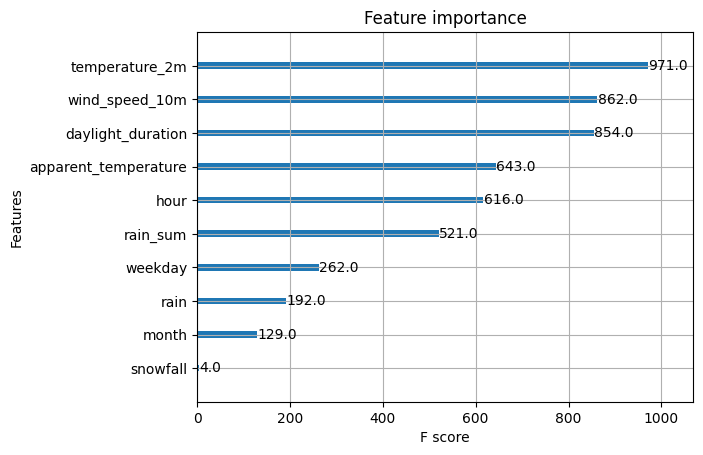

In [22]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor_1)
feature_importance_path = images_dir + "/feature_importance_1.png"
plt.savefig(feature_importance_path)
plt.show()

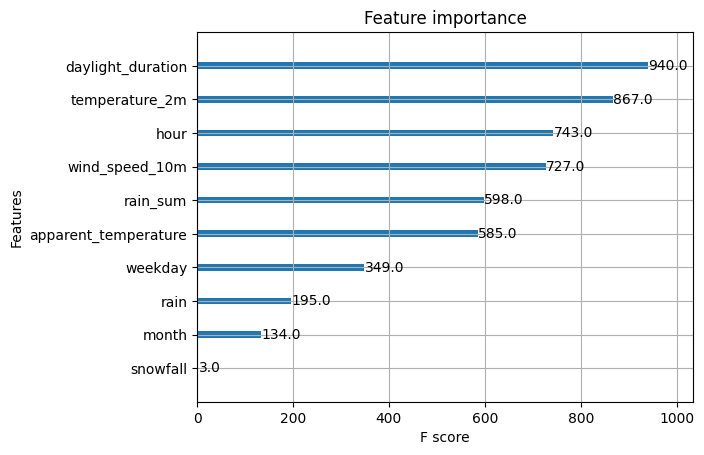

In [23]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor_2)
feature_importance_path = images_dir + "/feature_importance_2.png"
plt.savefig(feature_importance_path)
plt.show()

## Model Schema

In [27]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train_1)
output_schema = Schema(y_train_1)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [28]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor_1.save_model(model_dir + "/model_1.json")
xgb_regressor_2.save_model(model_dir + "/model_2.json")

In [29]:
res_dict_1 = { 
        "MSE": str(mse_1),
        "R squared": str(r2_1),
    }

res_dict_2 = {
        "MSE": str(mse_2),
        "R squared": str(r2_2),
    }

In [30]:
mr = project.get_model_registry()

aq_model_1 = mr.python.create_model(
    name="bike_availability_xgboost_model_1", 
    metrics= res_dict_1,
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="Bike availability prediction for " + STATION_1 + " in " + CITY + " using XGBoost",
)

aq_model_2 = mr.python.create_model(
    name="bike_availability_xgboost_model_2", 
    metrics= res_dict_2,
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="Bike availability prediction for " + STATION_2 + " in " + CITY + " using XGBoost",
)

aq_model_1.save(model_dir)
aq_model_2.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/572442 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/581159 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/42371 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/42358 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/26535 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/26553 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/156 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/973 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1207494/models/bike_availability_xgboost_model_1/1


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/572442 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/581159 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/42371 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/42358 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/26535 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/26553 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/128 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/973 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1207494/models/bike_availability_xgboost_model_2/1


Model(name: 'bike_availability_xgboost_model_2', version: 1)